In [ ]:
pip install osmnx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.9/102.9 kB 1.4 MB/s eta 0:00:00


In [ ]:
pip install overpy

### **Code to Look up Transportation Networks Around Stations**

Enter Facility ID: 1991


<ipython-input-16-b7d28d968390>:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


Number of intersections: 35


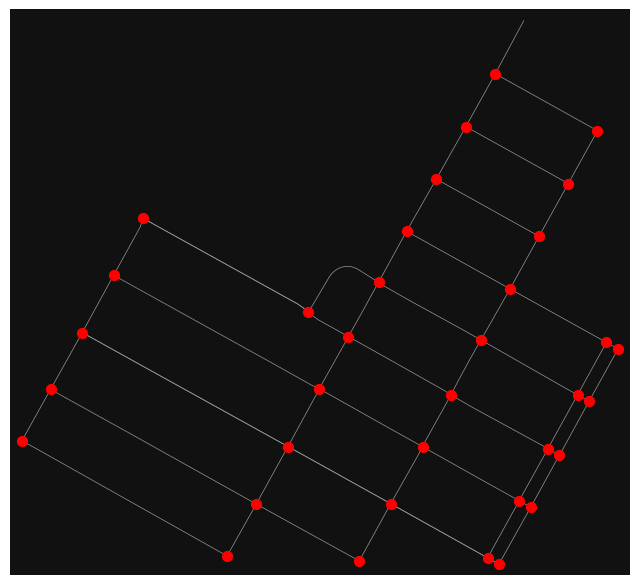

In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file
coords_df = pd.read_csv('/content/MTA_NYCT2.csv')  # Replace with your file path

# Function to get latitude and longitude from Facility ID
def get_lat_lon(facility_id, df):
    facility_row = df[df['Facility ID'] == facility_id]
    if facility_row.empty:
        raise ValueError("Facility ID not found in the dataset.")
    return facility_row.iloc[0]['Latitude'], facility_row.iloc[0]['Longitude']

# Ask for Facility ID
facility_id_input = int(input("Enter Facility ID: "))

# Get the corresponding latitude and longitude
lat, lon = get_lat_lon(facility_id_input, coords_df)

distance = 400  # 1/4 mile in meters

# Configure OSMnx
ox.config(use_cache=True, log_console=True)

# Define the Overpass QL filter for the custom query
custom_filter = '["highway"~"residential|secondary|primary"]'

# Create the network graph from OSM data
G = ox.graph_from_point((lat, lon), dist=distance, custom_filter=custom_filter)

# Check if the graph contains edges
if len(G.edges) == 0:
    raise ValueError("The graph contains no edges. Check the filter or increase the search radius.")

# Extract intersections
intersections = [node for node, degree in dict(G.degree).items() if degree > 1]

# Print out the number of intersections
print(f'Number of intersections: {len(intersections)}')

# Plot the street network and highlight the intersections
fig, ax = ox.plot_graph(G, node_color='black', node_size=0, edge_linewidth=0.5, show=False, close=False)

# Get the locations of the intersections
intersection_locs = [(data['x'], data['y']) for node, data in G.nodes(data=True) if node in intersections]
ax.scatter([loc[0] for loc in intersection_locs], [loc[1] for loc in intersection_locs], c='red', s=50, zorder=3)

plt.show()


### **Run Code to Analyze Intersections, Number of Streets, and Street Length Near Stations**

In [ ]:
import osmnx as ox
import networkx as nx
import pandas as pd
from google.colab import files

# Read in the list of coordinates from the uploaded CSV file
coords_df = pd.read_csv('/content/MTA_NYCT2.csv')  # Replace with your file path

# Modify the DataFrame to include separate columns for latitude and longitude
coords_df[['Latitude', 'Longitude']] = coords_df['coordinates'].str.extract(r'\(([^,]+), ([^\)]+)\)')

# Convert the extracted strings to float
coords_df['Latitude'] = coords_df['Latitude'].astype(float)
coords_df['Longitude'] = coords_df['Longitude'].astype(float)

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=[
    'Facility ID', 'Latitude', 'Longitude',
    'Number of Intersections', 'Number of Street Segments',
    'Average Street Segment Length', 'Number of Footways'
])

# Configure OSMnx
ox.config(use_cache=True, log_console=True)

# Loop through each row in the coordinates DataFrame
for index, row in coords_df.iterrows():
    lat, lon = row['Latitude'], row['Longitude']
    facility_id = row['Facility ID']
    distance = 400  # 1/4 mile in meters

    # Query filter for roads and footways
    custom_filter = '["highway"~"residential|secondary|primary|footway"]'
    G = ox.graph_from_point((lat, lon), dist=distance, custom_filter=custom_filter)
    G_projected = ox.project_graph(G)

    # Analyze connectivity
    intersections = len([node for node, degree in G_projected.degree() if degree > 1])
    street_segments = len(G_projected.edges)
    edge_lengths = [data['length'] for u, v, data in G_projected.edges(data=True)]
    average_street_length = sum(edge_lengths) / len(edge_lengths)

    # Count the number of footways
    footways = sum(1 for u, v, k, data in G_projected.edges(keys=True, data=True) if data['highway'] == 'footway')

    # Append results to the DataFrame
    results_df = results_df.append({
        'Facility ID': facility_id,
        'Latitude': lat, 'Longitude': lon,
        'Number of Intersections': intersections,
        'Number of Street Segments': street_segments,
        'Average Street Segment Length': average_street_length,
        'Number of Footways': footways
    }, ignore_index=True)

# Save the results to a CSV file
results_df.to_csv('street_network_analysis_results_with_footways.csv', index=False)

# Download the CSV file
files.download('street_network_analysis_results_with_footways.csv')


<ipython-input-11-a6ea88fef53a>:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)
<ipython-input-11-a6ea88fef53a>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-11-a6ea88fef53a>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-11-a6ea88fef53a>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-11-a6ea88fef53a>:47: FutureWarning: The frame.append method is depr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>